In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import skbio.diversity
import seaborn as sns
from gemelli.rpca import rpca
from gemelli.preprocessing import matrix_rclr
from gemelli.matrix_completion import MatrixCompletion
#from gemelli.factorization import rpca
from skbio.diversity import alpha_diversity
from skbio.diversity.alpha import shannon, simpson, chao1, observed_otus
from scipy.stats import mannwhitneyu
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, leaves_list
import matplotlib
from sklearn.decomposition import PCA

In [2]:
df = pd.read_csv("../cleaned_asv_df.csv")
gripstrength = pd.read_csv("../gripstrength.csv")

In [3]:
df

,Sample_ID,d0ab2c15400fe710288526c9a33083fb,21b04aaabca0f92a5ba0a0b2eaa31aea,0b0a4bdddb823efeb9984bf862fe81f8,c13359a9f895b1a2b9fcf49ceaea0e8a,0c870b228c94b71c91663a829ef6f119,91c9e0419bfe8038aed98cba9b51cb9d,629676293377721f621917a3f268dbce,91eadffc47a7950a37aae47e5e289b92,e73c0fa69ad4221f822e2e5dcb920e76,...,Group,Race_1.0,Race_2.0,Race_3.0,Race_4.0,Sex_1.0,Sex_2.0,Smoking_0.0,Smoking_1.0,Smoking_2.0
0,80004,391,694,1058,364,624,0,0,0,647,...,Worse,1,0,0,0,0,1,1,0,0
1,80001,2782,3982,2966,1084,5608,0,0,0,840,...,Better,1,0,0,0,0,1,1,0,0
2,80020,754,1524,6077,330,2481,0,161,24,182,...,Worse,1,0,0,0,0,1,0,1,0
3,80007,2547,3013,292,1254,170,0,0,0,411,...,Better,1,0,0,0,1,0,1,0,0
4,80019,243,48,3864,0,0,0,0,0,76,...,Worse,1,0,0,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306,43327,2258,0,2049,0,0,0,0,0,0,...,Worse,1,0,0,0,0,1,1,0,0
307,47170,703,277,12,3706,12,2830,0,1400,457,...,Worse,1,0,0,0,1,0,0,0,1
308,5703,974,2522,660,1000,51,0,0,39,597,...,Better,1,0,0,0,0,1,1,0,0
309,14654,816,2435,47,0,0,0,0,0,65,...,Better,1,0,0,0,1,0,0,0,1


In [82]:
"""
#Leave away, only done to filter the outer tertiles in terms of epigenetic age deviation to check if separation gets better

# Calculate the tertiles (33rd and 66th percentiles)
lower_tertile = df['Epigenetic_deviation'].quantile(0.33)
upper_tertile = df['Epigenetic_deviation'].quantile(0.66)

# Filter the DataFrame to remove samples in the middle tertile
df = df[(df['Epigenetic_deviation'] < lower_tertile) | 
        (df['Epigenetic_deviation'] > upper_tertile)].reset_index()
df = df.drop(columns="index")
"""

'\n#Leave away, only done to filter the outer tertiles in terms of epigenetic age deviation to check if separation gets better\n\n# Calculate the tertiles (33rd and 66th percentiles)\nlower_tertile = df[\'Epigenetic_deviation\'].quantile(0.33)\nupper_tertile = df[\'Epigenetic_deviation\'].quantile(0.66)\n\n# Filter the DataFrame to remove samples in the middle tertile\ndf = df[(df[\'Epigenetic_deviation\'] < lower_tertile) | \n        (df[\'Epigenetic_deviation\'] > upper_tertile)].reset_index()\ndf = df.drop(columns="index")\n'

In [4]:
#set up reads for RPCA

if 'Row_Sum' in df.columns:
    df = df.drop(columns=['Row_Sum'])
filtered_df = df

reads_filtered = df.iloc[:,1:-13]
group_labels = filtered_df['Group']

In [10]:
# DOING ROBUST CLR-TRANSFORM AND MATRIX COMPLETION USING OPTSPACE


# Assuming filtered_rclr is a numpy array (result from matrix_rclr)
filtered_rclr = matrix_rclr(reads_filtered)

# Step 1: Create an instance of MatrixCompletion with desired parameters
mc = MatrixCompletion(n_components=3, max_iterations=5, tol=1e-5)

# Step 2: Fit the model to the filtered_rclr matrix
mc.fit(filtered_rclr)

# Step 3: Access the results, e.g., the completed matrix, sample loadings, etc.
completed_matrix = pd.DataFrame(mc.solution)
pca_sample_scores = mc.sample_weights  # U matrix
feature_weights = mc.feature_weights  # V matrix
singular_values = mc.s
explained_variance = mc.explained_variance_ratio
distance_matrix = mc.distance

In [9]:
import pandas as pd

# Convert arrays to DataFrames
completed_matrix = pd.DataFrame(mc.solution)
pca_sample_scores = pd.DataFrame(mc.sample_weights)  # U matrix
feature_weights = pd.DataFrame(mc.feature_weights)  # V matrix
singular_values = pd.DataFrame(mc.s)
explained_variance = pd.Series(mc.explained_variance_ratio)
distance_matrix = pd.DataFrame(mc.distance)

# Save each result as a CSV file
completed_matrix.to_csv('completed_matrix.csv', index=False)
pca_sample_scores.to_csv('pca_sample_scores.csv', index=False)
feature_weights.to_csv('feature_weights.csv', index=False)
singular_values.to_csv('singular_values.csv', index=False)
explained_variance.to_csv('explained_variance.csv', index=False)
distance_matrix.to_csv('distance_matrix.csv', index=False)


In [10]:
# Step 1: Get the group labels and sort the samples based on the group
group_labels = filtered_df['Group'].values  # Group labels for each sample
sorted_indices = np.argsort(group_labels)  # Sort indices based on group

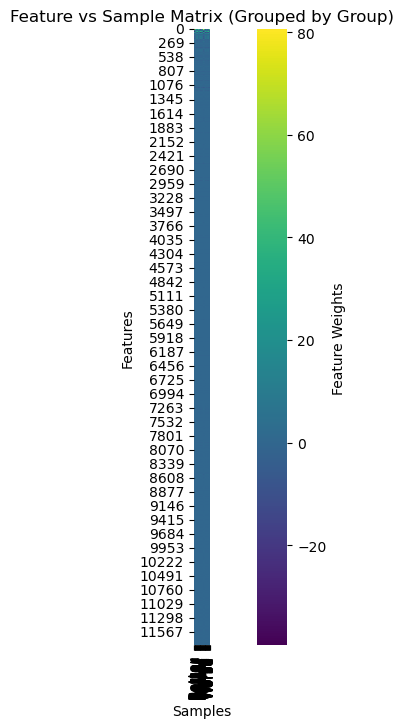

In [5]:



# Step 2: Reorder the sample_weights (U matrix) based on the sorted group indices
reordered_sample_weights = pca_sample_scores[sorted_indices, :]

# Step 3: Create a DataFrame for the heatmap with sorted group labels as columns and features as rows
# Convert feature_weights (V matrix) and sample_weights (U matrix) into a combined matrix
feature_vs_sample_matrix = np.dot(feature_weights, reordered_sample_weights.T)

# Create a DataFrame for the heatmap with features as index and sorted group labels as columns
sorted_group_labels = group_labels[sorted_indices]
feature_vs_sample_df = pd.DataFrame(feature_vs_sample_matrix, index=range(feature_weights.shape[0]), columns=sorted_group_labels)

# Step 4: Create a heatmap of the feature vs sample matrix
plt.figure(figsize=(12, 8))
sns.heatmap(feature_vs_sample_df, cmap='viridis', square=True, cbar_kws={'label': 'Feature Weights'})
plt.title('Feature vs Sample Matrix (Grouped by Group)')
plt.xlabel('Samples')
plt.ylabel('Features')
plt.savefig("Feature_Samples_Heatmap.png")
plt.show()


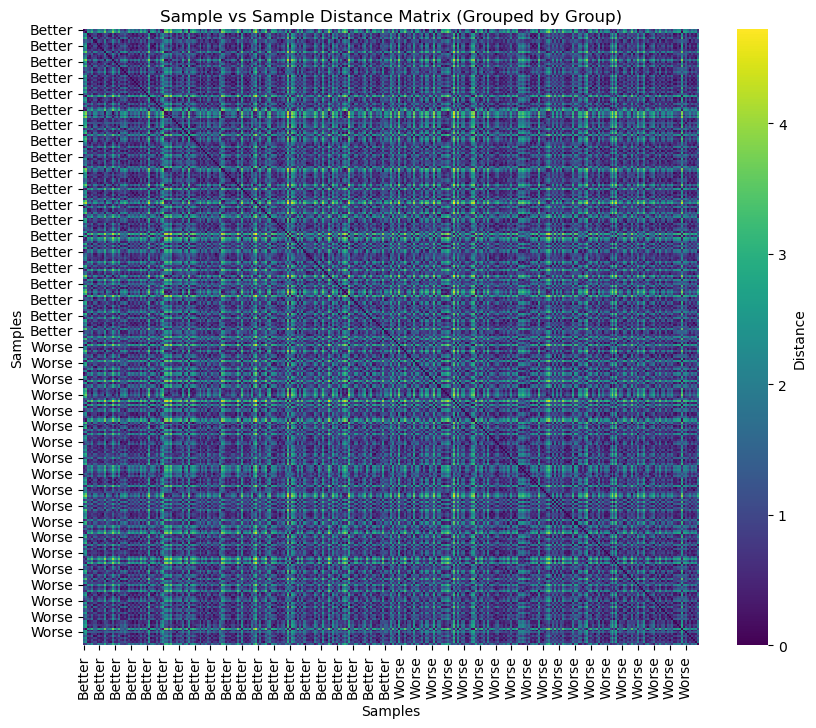

In [6]:
# Step 1: Get the group labels and sort the samples based on the group
group_labels = filtered_df['Group'].values  # Group labels for each sample
sorted_indices = np.argsort(group_labels)  # Sort indices based on group

# Step 2: Reorder the distance matrix based on the sorted group indices
reordered_distance_matrix = distance_matrix[sorted_indices, :][:, sorted_indices]

# Step 3: Create a DataFrame for the heatmap with sorted group labels as index/columns
sorted_group_labels = group_labels[sorted_indices]
distance_df = pd.DataFrame(reordered_distance_matrix, index=sorted_group_labels, columns=sorted_group_labels)

# Step 4: Create a heatmap of the reordered distance matrix
plt.figure(figsize=(10, 8))
sns.heatmap(distance_df, cmap='viridis', square=True, cbar_kws={'label': 'Distance'})
plt.title('Sample vs Sample Distance Matrix (Grouped by Group)')
plt.xlabel('Samples')
plt.ylabel('Samples')
plt.savefig("Distance_Matrix.png")
plt.show()

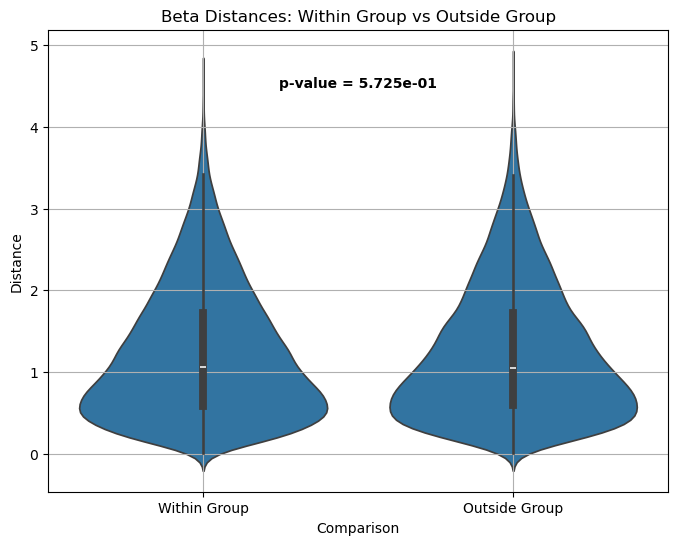

Mann-Whitney U test p-value: 0.572475718741737


In [7]:
# Step 1: Create lists to store pairwise distances and labels (within vs outside group)
within_group_distances = []
outside_group_distances = []

# Step 2: Calculate pairwise distances for within and outside groups
n_samples = distance_matrix.shape[0]
group_labels = filtered_df['Group'].values  # Group labels for each sample

for i in range(n_samples):
    for j in range(i + 1, n_samples):
        if group_labels[i] == group_labels[j]:  # Within group
            within_group_distances.append(distance_matrix[i, j])
        else:  # Outside group
            outside_group_distances.append(distance_matrix[i, j])

# Step 3: Perform Mann-Whitney U test
stat, p_value = mannwhitneyu(within_group_distances, outside_group_distances)

# Step 4: Create a DataFrame for plotting
distance_data = pd.DataFrame({
    'Distance': within_group_distances + outside_group_distances,
    'Comparison': ['Within Group'] * len(within_group_distances) + ['Outside Group'] * len(outside_group_distances)
})

# Step 5: Create a violin plot to compare within vs outside group distances
plt.figure(figsize=(8, 6))
sns.violinplot(x='Comparison', y='Distance', data=distance_data)

# Add p-value to the plot
plt.text(0.5, max(distance_data['Distance']) * 0.95, f'p-value = {p_value:.3e}', 
         horizontalalignment='center', size='medium', color='black', weight='semibold')

plt.title('Beta Distances: Within Group vs Outside Group')
plt.ylabel('Distance')
plt.xlabel('Comparison')
plt.grid(True)
plt.savefig("R_Aitchisons_Distance.png")
plt.show()

# Print p-value for clarity
print(f'Mann-Whitney U test p-value: {p_value}')


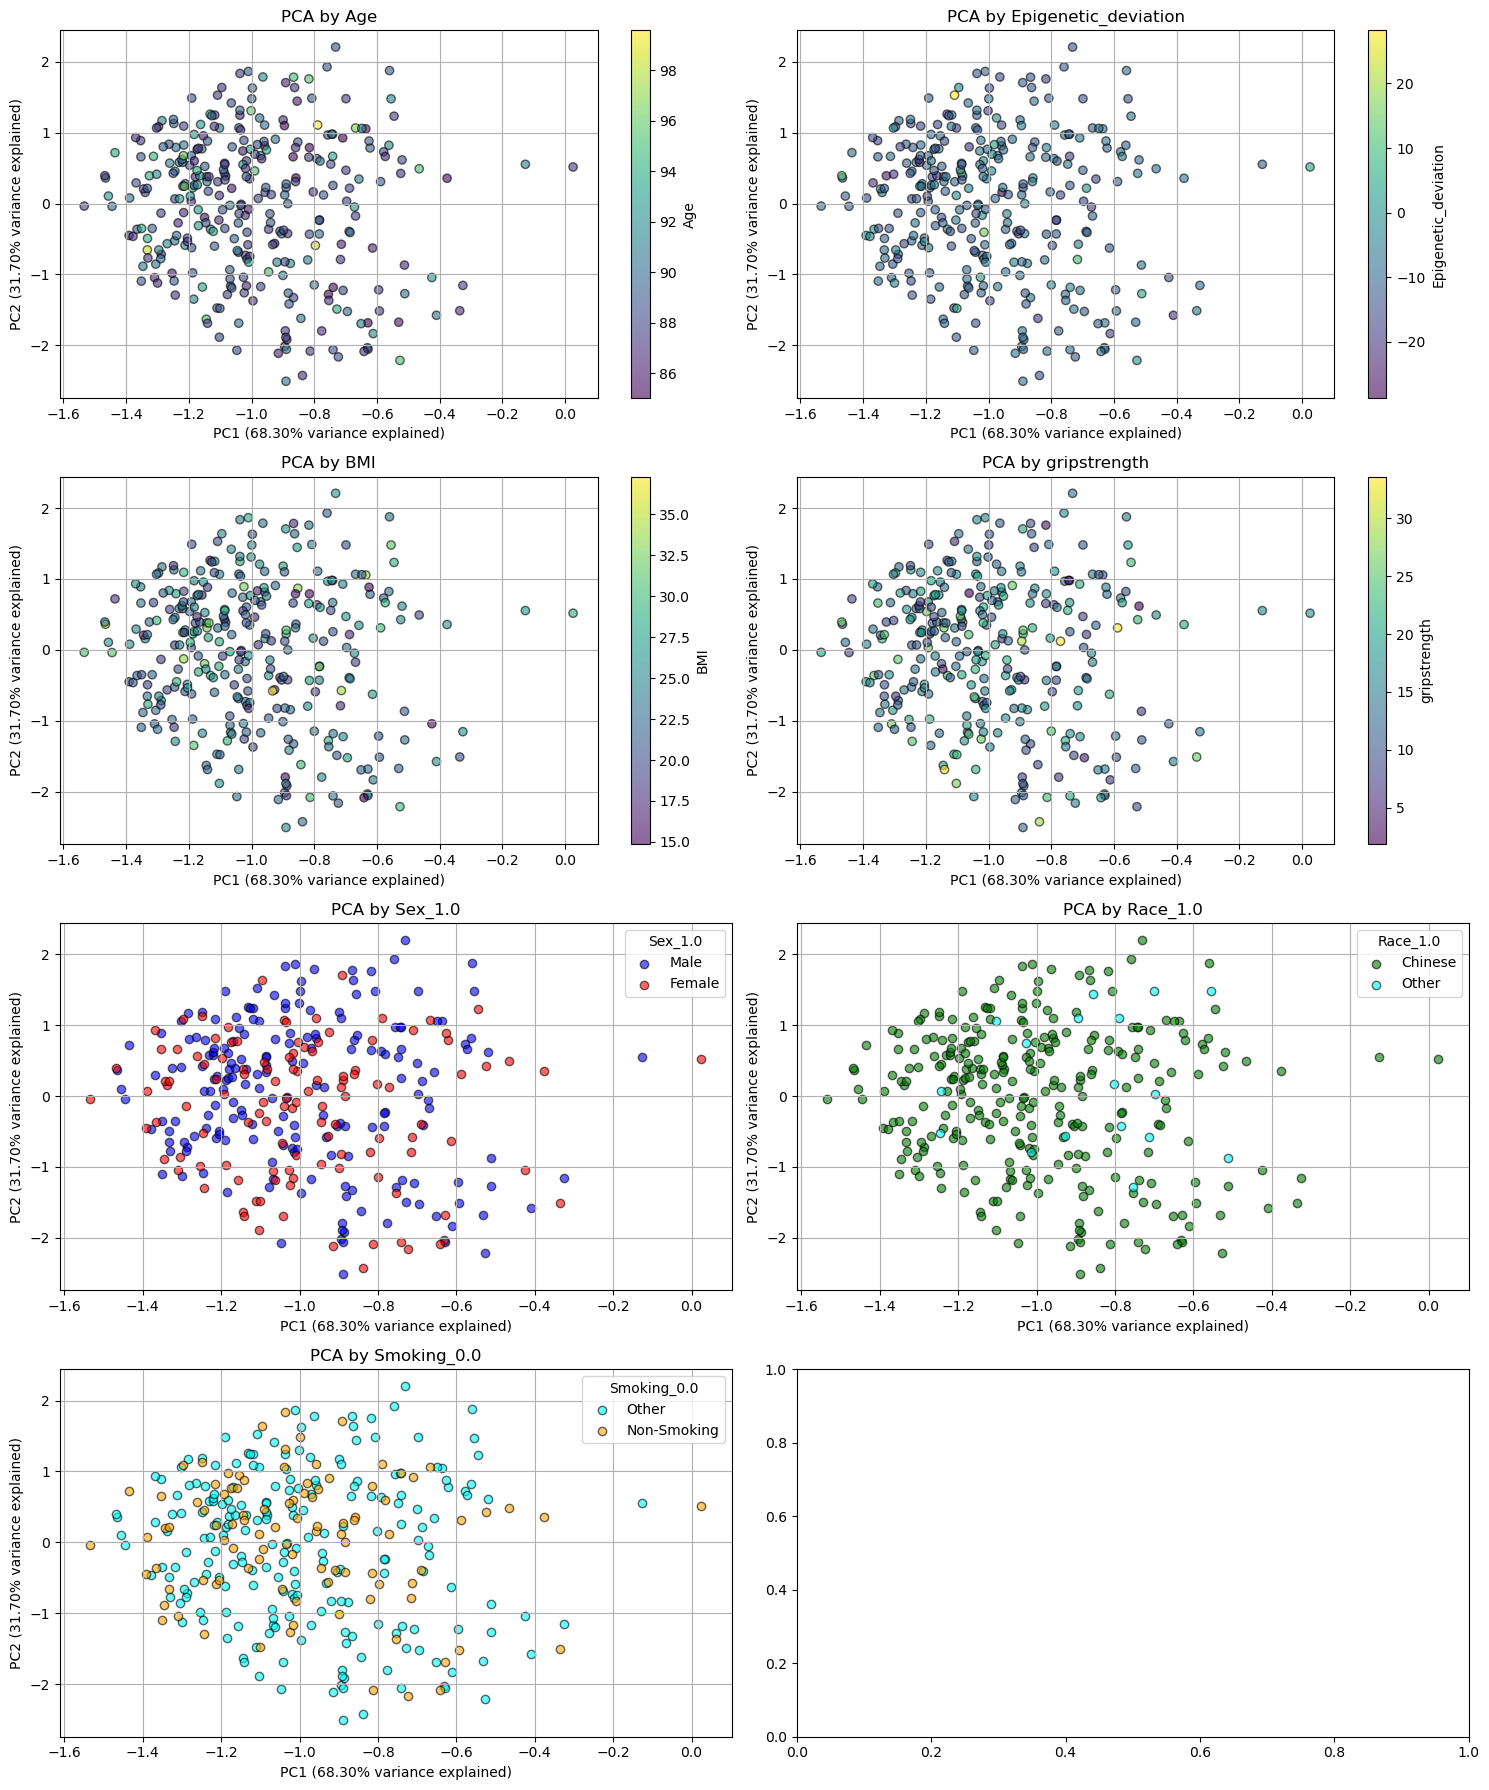

In [54]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define color palette or specific colors for the groups
colors = {
    'Female': 'red',
    'Male': 'blue',
    'Chinese': 'green',
    'Other': 'purple',
    'Non-Smoking': 'orange',
    'Other': 'cyan',
    'Better': 'blue',   # Add a unique color for "Better"
    'Worse': 'red'    # Add a unique color for "Worse"
}

# Define a fallback color palette for other variables
default_palette = sns.color_palette("husl", len(filtered_df['Group'].unique()))

# Variables of interest
variables = ['Age', 'Epigenetic_deviation', 'BMI', 'gripstrength', 'Sex_1.0', 'Race_1.0', 'Smoking_0.0']

# Group labels for categorical variables
group_labels = {
    'Sex_1.0': {1.0: 'Female', 0.0: 'Male'},
    'Race_1.0': {1.0: 'Chinese', 0.0: 'Other'},
    'Smoking_0.0': {0.0: 'Non-Smoking', 1.0: 'Other'}
}

# Create subplots for each variable
fig, axes = plt.subplots(4, 2, figsize=(15, 18))
axes = axes.flatten()

# Loop through variables to generate PCA plots with density
for i, var in enumerate(variables):
    ax = axes[i]
    
    # For continuous variables, use a scatter plot with a color gradient and density plot
    if var in ['Age', 'BMI', "Epigenetic_deviation", "gripstrength"]:
        scatter = ax.scatter(
            pca_sample_scores[:, 0],  # PC1
            pca_sample_scores[:, 1],  # PC2
            c=filtered_df[var],       # Continuous variable for color
            cmap='viridis',
            alpha=0.6,
            edgecolor='k'
        )
        plt.colorbar(scatter, ax=ax, label=var)
        
        # Density plot for continuous variables with the same color as points
        """
        sns.kdeplot(
            x=pca_sample_scores[:, 0],
            y=pca_sample_scores[:, 1],
            ax=ax,
            fill=True,
            #cmap='viridis',  # Use the same color map for density
            alpha=0.3,
            thresh=0.05,
            levels=5
        )
        """

    # For categorical variables, use different colors for each category and add density
    else:
        unique_groups = filtered_df[var].unique()
        label_dict = group_labels.get(var, {g: g for g in unique_groups})
        
        for group in unique_groups:
            group_indices = filtered_df[var] == group
            group_label = label_dict[group]
            color = colors.get(group_label, 'blue')  # Get the color for the group
            
            # Scatter plot
            ax.scatter(
                pca_sample_scores[group_indices, 0],  # PC1
                pca_sample_scores[group_indices, 1],  # PC2
                label=group_label,
                alpha=0.6,
                color=color,  # Set scatter color
                edgecolor='k'
            )
            
        
        ax.legend(title=var)

    # Add axis labels and titles
    ax.set_xlabel('PC1 (%.2f%% variance explained)' % (explained_variance[0] * 100))
    ax.set_ylabel('PC2 (%.2f%% variance explained)' % (explained_variance[1] * 100))
    ax.set_title(f'PCA by {var}')
    ax.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()

# Save the full figure with all variables
fig.savefig('all_combined_pca_plots.png', dpi=300)




/tmp/ipykernel_179/2003426796.py:35: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=df, x='PC1', hue='Group', common_norm=False, fill=True, alpha=0.2, ax=ax1)
/tmp/ipykernel_179/2003426796.py:39: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=df, x='PC2', hue='Group', common_norm=False, fill=True, alpha=0.2, ax=ax2)


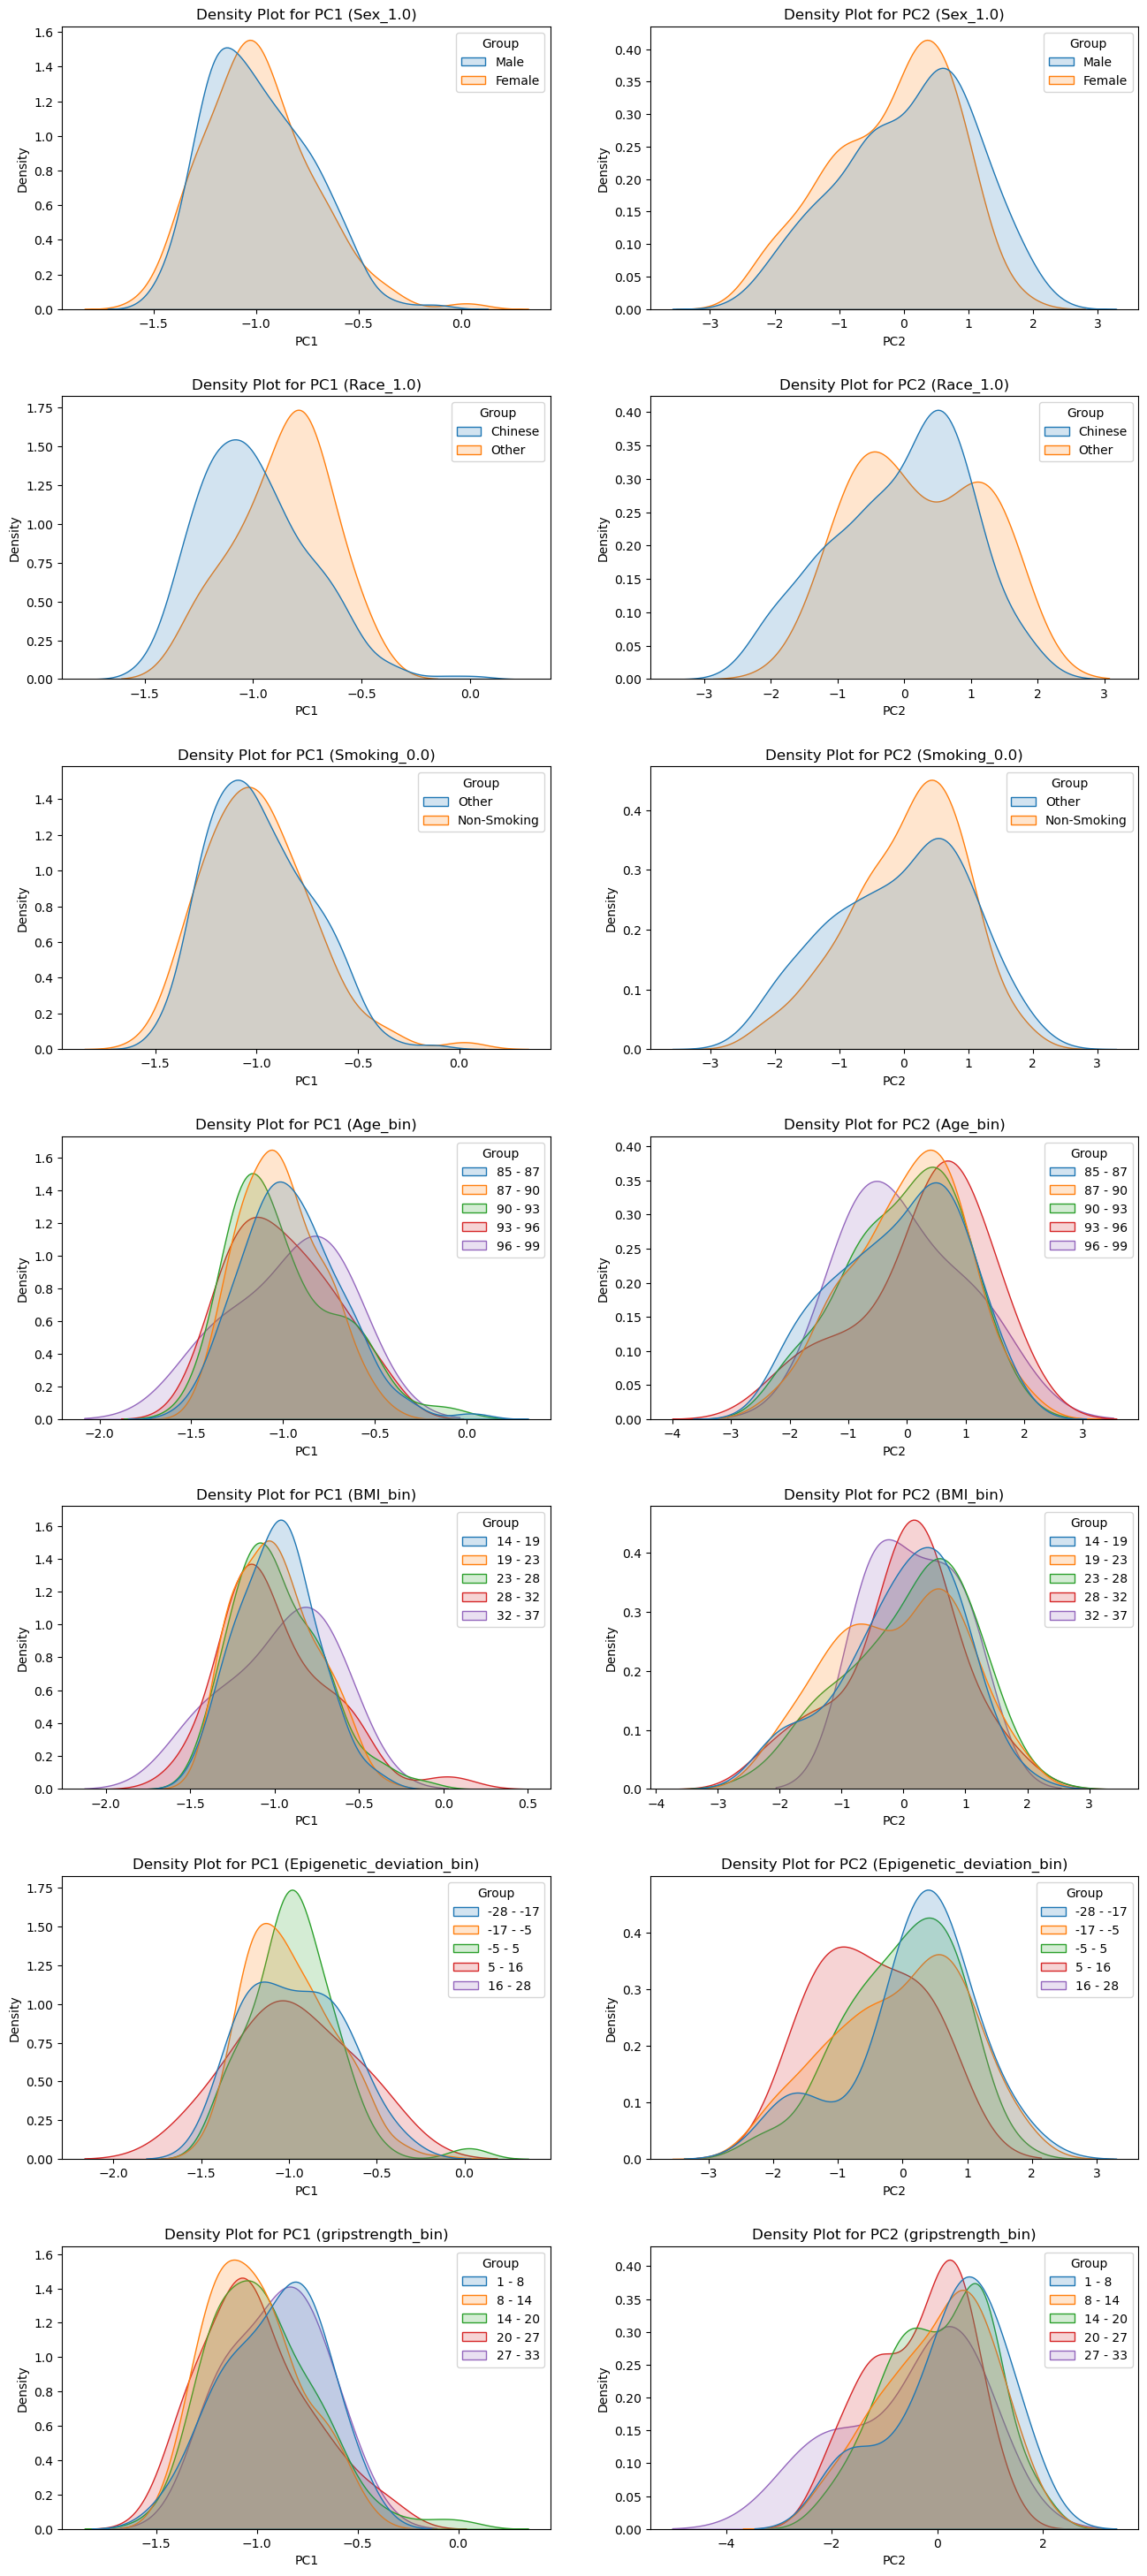

In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Example data - replace with actual data
# pca_sample_scores = np.random.randn(100, 2)
# continuous_variables_data = {
#     'Age': np.random.uniform(20, 80, 100),
#     'BMI': np.random.uniform(18, 35, 100),
#     'Epigenetic_deviation': np.random.uniform(-5, 5, 100),
#     'gripstrength': np.random.uniform(10, 50, 100)
# }

# Define categorical labels
group_labels = {
    'Sex_1.0': {1.0: 'Female', 0.0: 'Male'},
    'Race_1.0': {1.0: 'Chinese', 0.0: 'Other'},
    'Smoking_0.0': {0.0: 'Non-Smoking', 1.0: 'Other'}
}

# Define continuous variables
continuous_vars = ['Age', 'BMI', 'Epigenetic_deviation', 'gripstrength']

# Create DataFrame
pca = pd.DataFrame({
    'PC1': pca_sample_scores[:, 0],
    'PC2': pca_sample_scores[:, 1]
    #**continuous_variables_data  # Ensure your actual continuous data is in this format
})

# Function to plot density plots
def plot_density_grid(df, variable, labels, ax1, ax2):
    df['Group'] = df[variable].map(labels) if variable in group_labels else df[variable]
    sns.kdeplot(data=df, x='PC1', hue='Group', common_norm=False, fill=True, alpha=0.2, ax=ax1)
    ax1.set_title(f'Density Plot for PC1 ({variable})')
    ax1.set_xlabel('PC1')
    ax1.set_ylabel('Density')
    sns.kdeplot(data=df, x='PC2', hue='Group', common_norm=False, fill=True, alpha=0.2, ax=ax2)
    ax2.set_title(f'Density Plot for PC2 ({variable})')
    ax2.set_xlabel('PC2')
    ax2.set_ylabel('Density')

# Create a 7x2 grid for both categorical and continuous variables (3 categorical + 4 continuous)
fig, axes = plt.subplots(7, 2, figsize=(14, 30))
fig.tight_layout(pad=5.0)

# Plot for categorical variables
for i, (variable, labels) in enumerate(group_labels.items()):
    pca[variable] = df[variable]
    plot_density_grid(pca, variable, labels, axes[i, 0], axes[i, 1])

# Plot for continuous variables (binned with value ranges)
for j, variable in enumerate(continuous_vars, start=len(group_labels)):
    # Create bins with value ranges as labels, diff number bins for epigenetic deviation?
    if variable == 'Epigenetic_deviation':
        bins = pd.cut(df[variable], bins=5)
        bin_labels = [f'{int(interval.left)} - {int(interval.right)}' for interval in bins.cat.categories]
        pca[variable + '_bin'] = pd.cut(df[variable], bins=5, labels=bin_labels)
    else:
        bins = pd.cut(df[variable], bins=5)
        bin_labels = [f'{int(interval.left)} - {int(interval.right)}' for interval in bins.cat.categories]
        pca[variable + '_bin'] = pd.cut(df[variable], bins=5, labels=bin_labels)
    
    # Plot with value ranges as labels
    plot_density_grid(pca, variable + '_bin', None, axes[j, 0], axes[j, 1])

plt.savefig("densities.png")
plt.show()
